# Reflectivity Comparison

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy
import numpy as np

In [2]:
def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap

def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm

cmap, norm = radar_norm()

In [3]:
#load in the WRF geog file
geog = xr.open_dataset('/home/scratch/jcorner1/NWP_Project/geo_em.d01.nc')
new_geog = geog.drop({'XLAT_U', 'XLAT_V', 'XLONG_U', 'XLONG_V'})

## MRMS Observation

In [4]:
#open the MRMS dataset
ds_mrms = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/Other_Data/MRMS/*.nc4', concat_dim="Time", combine="nested")
ds_mrms

<xarray.Dataset>
Dimensions:     (lon: 7000, lat: 3500, Time: 10)
Coordinates:
  * lon         (lon) float32 -130.0 -130.0 -130.0 ... -60.03 -60.02 -60.01
  * lat         (lat) float32 20.0 20.01 20.02 20.03 ... 54.96 54.97 54.98 54.99
Dimensions without coordinates: Time
Data variables:
    mrms_lcref  (Time, lat, lon) float64 dask.array<chunksize=(1, 3500, 7000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [5]:
#subset paticular values
mrms_lat = ds_mrms.lat.values
mrms_lon = ds_mrms.lon.values
mrms_val = ds_mrms.mrms_lcref

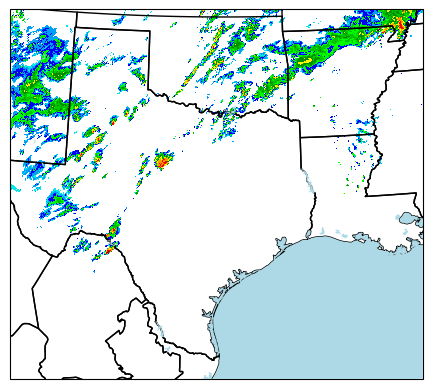

In [6]:
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(mrms_lon, mrms_lat, mrms_val[3,:,:].values, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

## NSSL 7-Class Single Moment

In [7]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data1/AFWA*00:00', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_nsslsm = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_nsslsm

<xarray.Dataset>
Dimensions:         (Time: 10, south_north: 432, west_east: 515,
                     south_north_stag: 433, west_east_stag: 516, land_cat: 20,
                     soil_cat: 16, month: 12, dust_erosion_dimension: 3)
Coordinates:
    lat             (south_north, west_east) float32 ...
    lon             (south_north, west_east) float32 ...
    x               (west_east) int64 0 1 2 3 4 5 6 ... 509 510 511 512 513 514
    y               (south_north) int64 0 1 2 3 4 5 ... 426 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/80)
    Times           (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    WSPD10MAX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_UP_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_DN_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    REFD_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    UP_HELI_MAX     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ...              ...
    OL4             (south_north, west_east) float32 ...
    VAR_SSO         (south_north, west_east) float32 ...
    LAKE_DEPTH      (south_north, west_east) float32 ...
    EROD            (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC        (south_north, west_east) float32 ...
    SANDFRAC        (south_north, west_east) float32 ...
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.3.3 MODEL
    START_DATE:                      2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              3750.0
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [8]:
#subset paticular values
nsslsm_lat = ds_nsslsm.lat.values
nsslsm_lon = ds_nsslsm.lon.values
nsslsm_val = ds_nsslsm.REFD_COM

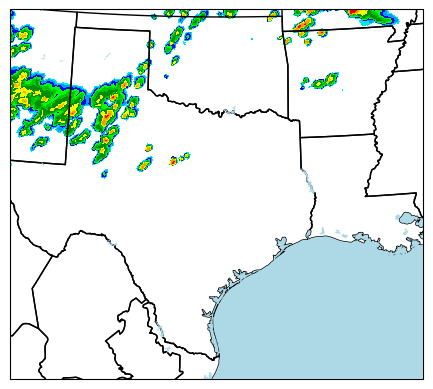

In [9]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(nsslsm_lon, nsslsm_lat, nsslsm_val[3,:,:].values, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

## NSSL Double Moment

In [10]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data5/AFWA*00:00', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_nssldm = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_nssldm

<xarray.Dataset>
Dimensions:         (Time: 10, south_north: 432, west_east: 515,
                     south_north_stag: 433, west_east_stag: 516, land_cat: 20,
                     soil_cat: 16, month: 12, dust_erosion_dimension: 3)
Coordinates:
    lat             (south_north, west_east) float32 ...
    lon             (south_north, west_east) float32 ...
    x               (west_east) int64 0 1 2 3 4 5 6 ... 509 510 511 512 513 514
    y               (south_north) int64 0 1 2 3 4 5 ... 426 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/80)
    Times           (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    WSPD10MAX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_UP_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_DN_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    REFD_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    UP_HELI_MAX     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ...              ...
    OL4             (south_north, west_east) float32 ...
    VAR_SSO         (south_north, west_east) float32 ...
    LAKE_DEPTH      (south_north, west_east) float32 ...
    EROD            (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC        (south_north, west_east) float32 ...
    SANDFRAC        (south_north, west_east) float32 ...
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.3.3 MODEL
    START_DATE:                      2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              3750.0
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [11]:
#subset paticular values
nssldm_lat = ds_nssldm.lat.values
nssldm_lon = ds_nssldm.lon.values
nssldm_val = ds_nssldm.REFD_COM

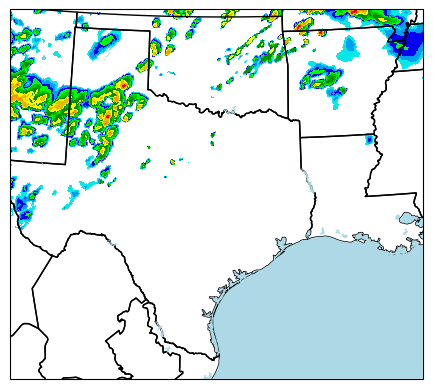

In [12]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(nssldm_lon, nssldm_lat, nssldm_val[3,:,:].values, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

## Thompson (Hail)

In [13]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data4/wrfo*00:00', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_th = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_th

<xarray.Dataset>
Dimensions:                (Time: 10, south_north: 432, west_east: 515,
                            bottom_top: 49, bottom_top_stag: 50,
                            soil_layers_stag: 6, west_east_stag: 516,
                            south_north_stag: 433, seed_dim_stag: 33,
                            land_cat: 20, soil_cat: 16, month: 12,
                            dust_erosion_dimension: 3)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 432, 516), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 432, 516), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 433, 515), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 433, 515), meta=np.ndarray>
    lat                    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    lon                    (south_north, west_east) float32 ...
    x                      (west_east) int64 0 1 2 3 4 5 ... 510 511 512 513 514
    y                      (south_north) int64 0 1 2 3 4 ... 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag,
                                seed_dim_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/293)
    Times                  (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(1, 49), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 6), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 6), meta=np.ndarray>
    ...                     ...
    OL3                    (south_north, west_east) float32 ...
    OL4                    (south_north, west_east) float32 ...
    LAKE_DEPTH             (south_north, west_east) float32 ...
    EROD                   (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC               (south_north, west_east) float32 ...
    SANDFRAC               (south_north, west_east) float32 ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2021-04-28_18:00:00
    SIMULATION_START_DATE:           2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [14]:
th_lat = ds_th.lat[0,:].values
th_lon = ds_th.lon.values
th_val = ds_th.REFD_COM

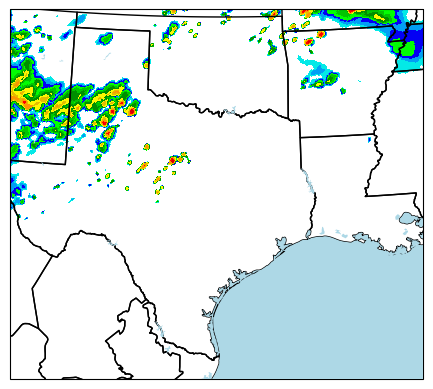

In [15]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(th_lon, th_lat, th_val[3,:,:].values, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

## HRRR (Comparison)

In [16]:
ds_hrrr = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/Other_Data/HRRR/hrrr.*.grib2', filter_by_keys={'typeOfLevel': 'atmosphere'}, concat_dim="valid_time", combine="nested")
ds_hrrr

<xarray.Dataset>
Dimensions:     (valid_time: 10, y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 2021-04-28T18:00:00
    step        (valid_time) timedelta64[ns] 00:00:00 01:00:00 ... 09:00:00
    atmosphere  float64 0.0
    latitude    (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * valid_time  (valid_time) datetime64[ns] 2021-04-28T18:00:00 ... 2021-04-2...
Dimensions without coordinates: y, x
Data variables:
    refc        (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown     (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    veril       (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    hail        (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ltng        (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    tcolw       (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    tcoli       (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    tcc         (valid_time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-12-03T19:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
hrrr_lon = ds_hrrr.longitude.values
hrrr_lat = ds_hrrr.latitude.values
hrrr_val = ds_hrrr.refc

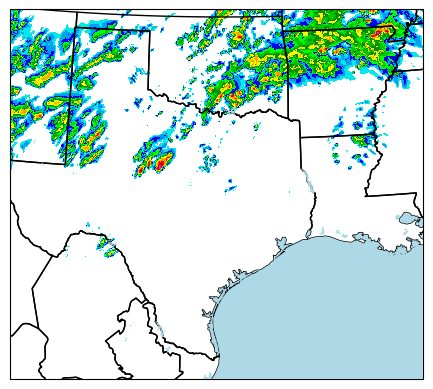

In [18]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(hrrr_lon, hrrr_lat, hrrr_val[3,:,:].values, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

## Comparison

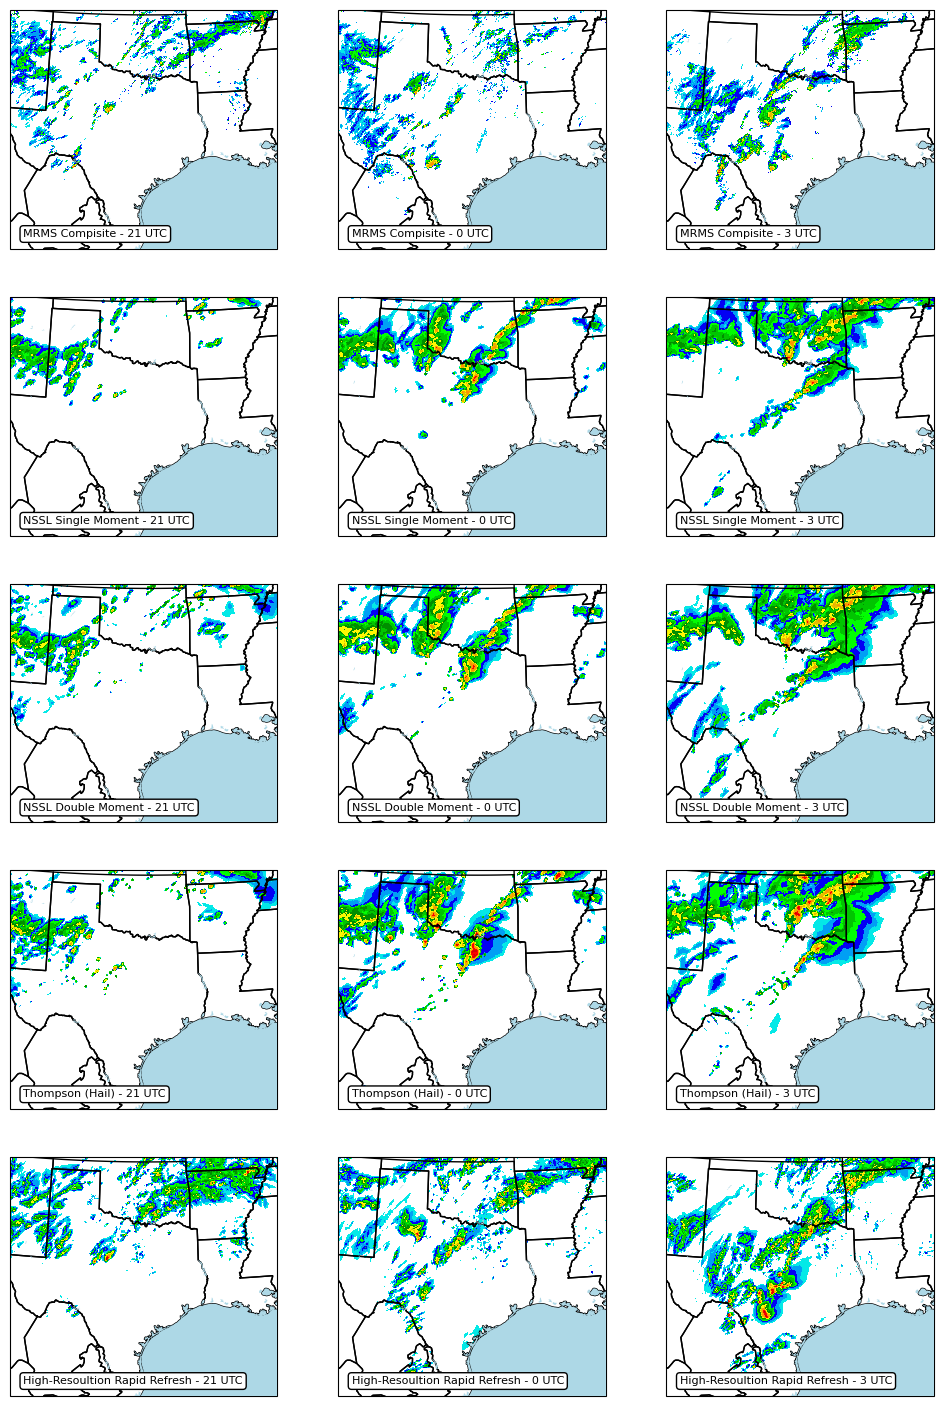

In [22]:
input_data = ['mrms', 'nsslsm', 'nssldm', 'th', 'hrrr']
labels = ['MRMS Compisite', 'NSSL Single Moment', 'NSSL Double Moment', 'Thompson (Hail)', 'High-Resoultion Rapid Refresh']

fig = plt.figure()
fig.set_size_inches(12, 18)

step = 1

for i in range(len(input_data)):
    for timestep in range(len([3,6,9])):
        
        #plot the hail data
        ax = plt.subplot(5,3,step, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
        c = ax.pcolormesh(locals()[f'{input_data[int(i)]}_lon'], locals()[f'{input_data[int(i)]}_lat'], locals()[f'{input_data[int(i)]}_val'][[3,6,9][timestep],:,:].values, 
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)

        #add features
        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
        ax.set_extent([-104.5,-90,25,37])

        ax.annotate(f'{labels[int(i)]} - {[21,0,3][timestep]} UTC', (0.05,0.05), xycoords='axes fraction',fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)
        step = step +1

Text(0.55, 0.05, 'NSSL Single Moment')

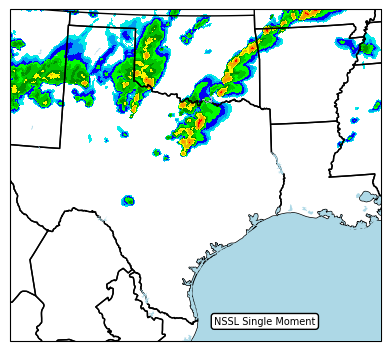

In [20]:
fig = plt.figure()
fig.set_size_inches(25, 25)

j = 6

ax = plt.subplot(5,3,i+1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(locals()[f'{input_data[int(i/3)]}_lon'], locals()[f'{input_data[int(i/3)]}_lat'], locals()[f'{input_data[int(i/3)]}_val'][6,:,:].values, 
                  transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)

#add features
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
ax.set_extent([-104.5,-90,25,37])

ax.annotate(f'{labels[int(i/3)]}', (0.55,0.05), xycoords='axes fraction',fontsize=7, 
            bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)

In [21]:
[3,6,9][0]

3